# Voronoi Structure Analysis (New File)

This notebook provides a detailed structural analysis of the midge swarm using Voronoi tessellation.
It focuses on visualizing the internal structure through layered network graphs and radial density distributions.

## Key Features:
1.  **Layer Classification**: Particles are classified into Inner, Middle, and Outer layers based on local density (Voronoi volume).
2.  **Network Visualization**: Displays the swarm as a network of connected nodes, colored by layer, to reveal the topological structure.
3.  **Radial Distribution**: Analyzes how these layers are distributed spatially relative to the swarm center.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, ConvexHull
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
import swarm
import os

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

## 1. Load Data

In [33]:
# Dataset Path
folder = "d:/3Ddataset/"

if os.path.exists(folder):
    print(f"Loading data from {folder}...")
    dfs = swarm.read_swarm_batch(folder, start=2, end=2)
    df_raw = dfs["df2"]
else:
    print("Path not found. Checking current directory...")
    if os.path.exists("Ob1.txt"):
        df_raw = swarm._read_one_file("Ob1.txt")
    else:
        raise FileNotFoundError(f"Cannot find dataset in {folder} or current directory.")

print("Preprocessing...")
df = swarm.preprocess_full(df_raw)

# --- 1. Frame Analysis & Selection Helpers ---
frame_counts = df.groupby('t').size()
frames = sorted(df['t'].unique())

print(f"Available frames: {min(frames):.3f} to {max(frames):.3f} (Total {len(frames)} frames)")
print(f"Particle counts - Min: {frame_counts.min()}, Max: {frame_counts.max()}, Mean: {frame_counts.mean():.1f}")

# --- 2. Feature: Find Frames by Particle Count ---
# Set this to a number (e.g., 50) to see which frames have exactly 50 particles.
SEARCH_PARTICLE_COUNT = 59 

if SEARCH_PARTICLE_COUNT is not None:
    matching_frames = frame_counts[frame_counts == SEARCH_PARTICLE_COUNT].index.tolist()
    print(f"\n[Search] Frames with exactly {SEARCH_PARTICLE_COUNT} particles:")
    if matching_frames:
        # Print first 20 matches to avoid spamming
        print(f"Found {len(matching_frames)} frames: {matching_frames[:20]} ...")
    else:
        print("No frames found with that exact count.")

# --- 3. Target Frame Selection ---
# Set specific frame time here (e.g. 1.05), or None to auto-select best frame
TARGET_FRAME = 0.91 

if TARGET_FRAME is not None:
    selected_t = min(frames, key=lambda x: abs(x - TARGET_FRAME))
    print(f"\n[Selection] Manual target: {TARGET_FRAME}. Using closest frame: {selected_t}")
else:
    selected_t = max(frames, key=lambda t: len(df[df['t'] == t]))
    print(f"\n[Selection] Auto-selected frame with most particles: {selected_t}")

frame_data = df[df['t'] == selected_t]
points = frame_data[['x', 'y', 'z']].values

print(f"Selected Frame: t={selected_t:.3f}, Particles: {len(points)}")


Loading data from d:/3Ddataset/...
Preprocessing...
Available frames: 0.070 to 148.650 (Total 14859 frames)
Particle counts - Min: 46, Max: 86, Mean: 68.3

[Search] Frames with exactly 59 particles:
Found 262 frames: [0.91, 0.96, 0.97, 0.98, 1.44, 1.45, 1.46, 1.49, 1.53, 1.57, 1.69, 2.19, 2.2, 2.24, 2.25, 2.3, 2.52, 2.56, 2.57, 2.65] ...

[Selection] Manual target: 0.91. Using closest frame: 0.91
Selected Frame: t=0.910, Particles: 59


## 2. Compute Voronoi & Classify Layers (Feng & Ouellette 2023 Method)
We classify particles into 3 layers based on the method described in *Feng & Ouellette (2023)*:
- **Outer Layer**: Particles on the **Convex Hull** of the swarm (unbounded Voronoi cells).
- **Middle Layer**: Particles whose Voronoi cell centroid lies **outside** the swarm's Convex Hull.
- **Inner Layer**: Particles whose Voronoi cell centroid lies **inside** the swarm's Convex Hull.

This method accounts for the geometric "skewness" of the local environment near the swarm boundary.

In [34]:
def analyze_swarm_structure(points):
    # 1. Compute Global Convex Hull of Swarm
    global_hull = ConvexHull(points)
    hull_eqs = global_hull.equations
    
    # 2. Compute Voronoi Tessellation
    vor = Voronoi(points)
    
    volumes = []
    labels = np.zeros(len(points), dtype=int) # Default to 0 (Inner)
    
    # 3. Identify Outer Layer (Points on Global Hull)
    labels[global_hull.vertices] = 2 
    
    for i in range(len(points)):
        region_idx = vor.point_region[i]
        region = vor.regions[region_idx]
        
        if -1 in region or len(region) == 0:
            labels[i] = 2
            volumes.append(np.nan)
            continue
            
        try:
            verts = vor.vertices[region]
            # Compute Volume (optional)
            try:
                cell_hull = ConvexHull(verts)
                volumes.append(cell_hull.volume)
            except:
                volumes.append(np.nan)
            
            # If already marked as Outer (on global hull), skip geometric check
            if labels[i] == 2:
                continue
                
            # Compute Centroid of the Voronoi Cell (Mean of vertices)
            cell_centroid = np.mean(verts, axis=0)
            
            # Check if Centroid is inside Global Hull
            # dot(normal, p) + offset <= 0
            is_inside = np.all(np.dot(hull_eqs[:, :-1], cell_centroid) + hull_eqs[:, -1] <= 1e-7)
            
            if is_inside:
                labels[i] = 0 # Inner
            else:
                labels[i] = 1 # Middle
                
        except Exception as e:
            volumes.append(np.nan)
            labels[i] = 2 
            
    volumes = np.array(volumes)
    return vor, labels, volumes

vor, labels, volumes = analyze_swarm_structure(points)
print("Classification Counts (0=Inner, 1=Mid, 2=Outer):", np.bincount(labels))

Classification Counts (0=Inner, 1=Mid, 2=Outer): [31  6 22]


## 3. Visualization: Layered Network Graph
Visualizing the swarm as a connected network.
- **Red**: Inner Core
- **Green**: Middle Layer
- **Blue**: Outer Shell


[Edge Filter] Median Edge: 150.49 mm | Cutoff: 526.73 mm
[Graph Stats]
Nodes: 59
Valid Voronoi Neighbors: 350
Edges Drawn (after Ratio): 223
Connectivity (Valid Neighbors): 20.5% of all-to-all


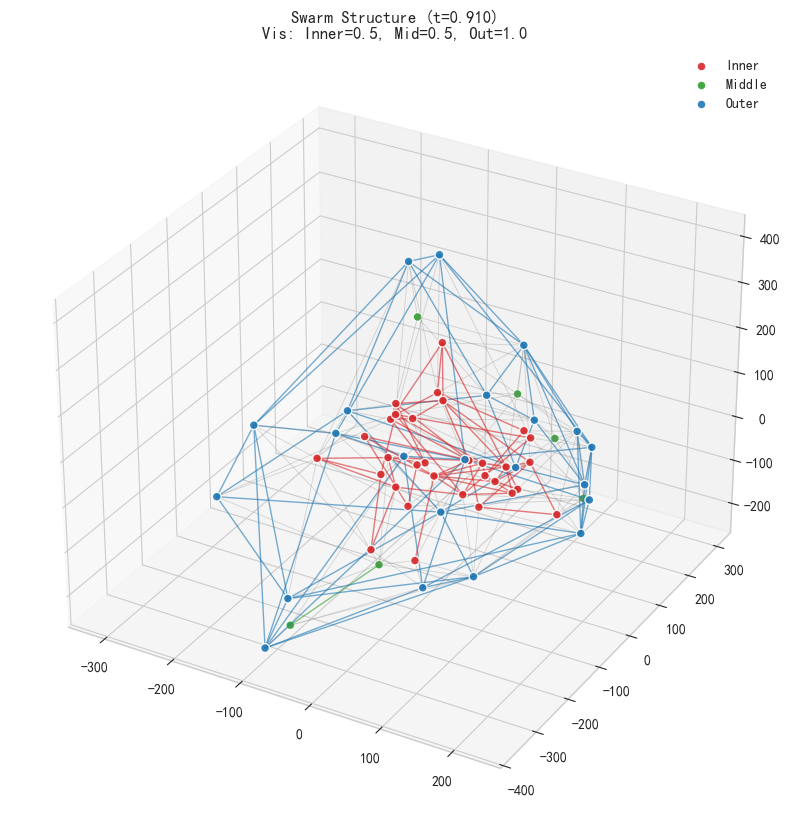

In [37]:
def plot_network(points, vor, labels):
    # --- Configuration: Visibility Ratios ---
    # Set these between 0.0 (hide all) and 1.0 (show all) to declutter specific layers
    VISIBILITY_RATIO = {
        'Inner': 0.5,   # Show 100% of Inner edges
        'Middle': 0.5,  # Show 50% of Middle edges
        'Outer': 1.0    # Show only 10% of Outer edges
    }
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['#d62728', '#2ca02c', '#1f77b4'] # Red, Green, Blue
    names = ['Inner', 'Middle', 'Outer']
    
    # 1. Plot Nodes
    for i in range(3):
        mask = (labels == i)
        ax.scatter(points[mask, 0], points[mask, 1], points[mask, 2], 
                   c=colors[i], label=names[i], s=40, edgecolors='w', alpha=0.9)
        
    # 2. Analyze Edge Lengths for Dynamic Filtering
    all_dists = []
    for p1_idx, p2_idx in vor.ridge_points:
        dist = np.linalg.norm(points[p1_idx] - points[p2_idx])
        all_dists.append(dist)
    
    # Heuristic: Filter edges > 3x median length (removes infinite/boundary artifacts)
    median_dist = np.median(all_dists)
    cutoff_dist = median_dist * 3.5 
    print(f"\n[Edge Filter] Median Edge: {median_dist:.2f} mm | Cutoff: {cutoff_dist:.2f} mm")
    
    # 3. Plot Edges with Ratios
    edge_count = 0
    drawn_count = 0
    np.random.seed(42) # Fixed seed for consistent visualization
    
    for p1_idx, p2_idx in vor.ridge_points:
        p1 = points[p1_idx]
        p2 = points[p2_idx]
        dist = np.linalg.norm(p1 - p2)
        
        if dist > cutoff_dist: continue 
        
        edge_count += 1
        l1, l2 = labels[p1_idx], labels[p2_idx]
        
        # Determine Layer & Visibility
        # If cross-layer, use the "Outer-most" layer's ratio (or average)
        # Here we prioritize the "Inner-most" layer to keep structure connected? 
        # Actually, user wants to control per layer. 
        # Let's say if it's purely Inner-Inner, use Inner ratio.
        # If Inner-Middle, maybe use max or min? Let's use the layer of p1 for simplicity or avg.
        
        should_draw = False
        
        if l1 == l2:
            layer_name = names[l1]
            ratio = VISIBILITY_RATIO[layer_name]
            if np.random.rand() < ratio:
                c = colors[l1]
                alpha = 0.6
                lw = 1.0
                should_draw = True
        else:
            # Cross-layer: Draw if BOTH layers allow it? Or just fixed low probability?
            # Let's make cross-layer edges dependent on the average ratio of the two
            avg_ratio = (VISIBILITY_RATIO[names[l1]] + VISIBILITY_RATIO[names[l2]]) / 2
            if np.random.rand() < avg_ratio:
                c = 'gray'
                alpha = 0.3
                lw = 0.6
                should_draw = True
                
        if should_draw:
            drawn_count += 1
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                    c=c, alpha=alpha, linewidth=lw)
    
    # Verification Print
    N = len(points)
    possible_edges = N * (N - 1) // 2
    print(f"[Graph Stats]")
    print(f"Nodes: {N}")
    print(f"Valid Voronoi Neighbors: {edge_count}")
    print(f"Edges Drawn (after Ratio): {drawn_count}")
    print(f"Connectivity (Valid Neighbors): {edge_count/possible_edges:.1%} of all-to-all")
                
    ax.set_title(f"Swarm Structure (t={selected_t:.3f})\nVis: Inner={VISIBILITY_RATIO['Inner']}, Mid={VISIBILITY_RATIO['Middle']}, Out={VISIBILITY_RATIO['Outer']}")
    ax.legend()
    plt.show()

plot_network(points, vor, labels)


In [38]:
# --- Interactive 3D Visualization using Plotly ---
import plotly.graph_objects as go
import numpy as np

def plot_interactive_network(points, vor, labels):
    # Configuration
    VISIBILITY_RATIO = {
        'Inner': 1.0,
        'Middle': 0.8,
        'Outer': 0.3 
    }
    
    colors_hex = ['#d62728', '#2ca02c', '#1f77b4']
    names = ['Inner', 'Middle', 'Outer']
    
    fig = go.Figure()
    
    # 1. Add Nodes
    for i in range(3):
        mask = (labels == i)
        subset = points[mask]
        
        fig.add_trace(go.Scatter3d(
            x=subset[:, 0], y=subset[:, 1], z=subset[:, 2],
            mode='markers',
            name=f'{names[i]} Nodes',
            marker=dict(
                size=5,
                color=colors_hex[i],
                opacity=0.9
            )
        ))

    # 2. Add Edges
    # Pre-calculate cutoff
    all_dists = []
    for p1_idx, p2_idx in vor.ridge_points:
        dist = np.linalg.norm(points[p1_idx] - points[p2_idx])
        all_dists.append(dist)
    median_dist = np.median(all_dists)
    cutoff_dist = median_dist * 3.5
    
    # Lists to store line coordinates for batch plotting
    edge_traces = {
        0: {'x': [], 'y': [], 'z': []}, # Inner
        1: {'x': [], 'y': [], 'z': []}, # Middle
        2: {'x': [], 'y': [], 'z': []}, # Outer
        'cross': {'x': [], 'y': [], 'z': []} # Cross-layer
    }
    
    np.random.seed(42)
    
    for p1_idx, p2_idx in vor.ridge_points:
        p1, p2 = points[p1_idx], points[p2_idx]
        dist = np.linalg.norm(p1 - p2)
        
        if dist > cutoff_dist: continue
        
        l1, l2 = labels[p1_idx], labels[p2_idx]
        
        # Determine category and visibility
        should_draw = False
        target_key = None
        
        if l1 == l2:
            target_key = l1
            if np.random.rand() < VISIBILITY_RATIO[names[l1]]:
                should_draw = True
        else:
            target_key = 'cross'
            avg_ratio = (VISIBILITY_RATIO[names[l1]] + VISIBILITY_RATIO[names[l2]]) / 2
            if np.random.rand() < avg_ratio:
                should_draw = True
                
        if should_draw:
            t = edge_traces[target_key]
            t['x'].extend([p1[0], p2[0], None])
            t['y'].extend([p1[1], p2[1], None])
            t['z'].extend([p1[2], p2[2], None])
            
    # Add Edge Traces to Figure
    # Intra-layer
    for i in range(3):
        t = edge_traces[i]
        if t['x']:
            fig.add_trace(go.Scatter3d(
                x=t['x'], y=t['y'], z=t['z'],
                mode='lines',
                name=f'{names[i]} Edges',
                line=dict(color=colors_hex[i], width=4),
                opacity=0.5
            ))
            
    # Cross-layer
    t = edge_traces['cross']
    if t['x']:
        fig.add_trace(go.Scatter3d(
            x=t['x'], y=t['y'], z=t['z'],
            mode='lines',
            name='Cross Edges',
            line=dict(color='gray', width=2),
            opacity=0.3
        ))
        
    fig.update_layout(
        title=f"Interactive Swarm Structure (t={selected_t:.3f})",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    fig.show()

plot_interactive_network(points, vor, labels)


## 4. Visualization: Radial PDF
Verifying the spatial arrangement by plotting the distribution of distance to center for each layer.

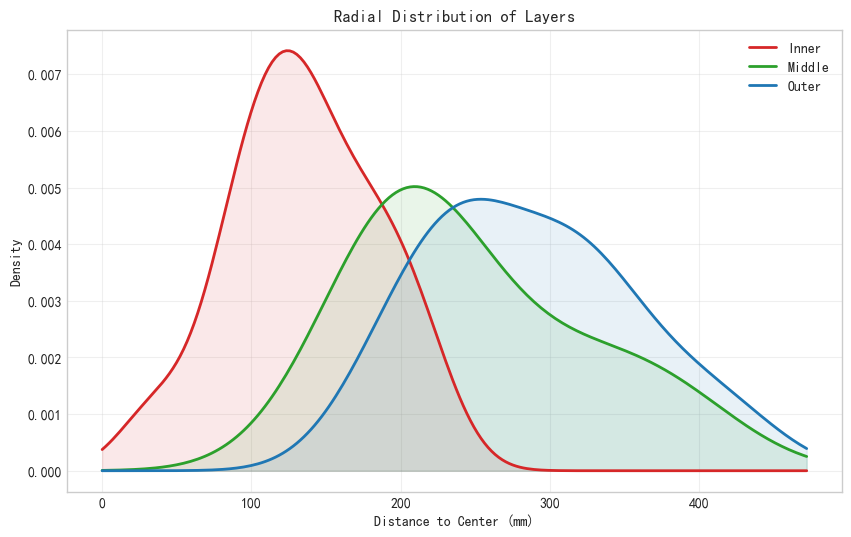

In [39]:
def plot_radial_pdf(points, labels):
    centroid = np.mean(points, axis=0)
    dists = np.linalg.norm(points - centroid, axis=1)
    
    colors = ['#d62728', '#2ca02c', '#1f77b4']
    names = ['Inner', 'Middle', 'Outer']
    
    plt.figure(figsize=(10, 6))
    x_vals = np.linspace(0, dists.max()*1.1, 200)
    
    for i in range(3):
        subset_dists = dists[labels == i]
        if len(subset_dists) > 2:
            kde = gaussian_kde(subset_dists)
            plt.plot(x_vals, kde(x_vals), color=colors[i], label=names[i], lw=2)
            plt.fill_between(x_vals, kde(x_vals), color=colors[i], alpha=0.1)
            
    plt.title("Radial Distribution of Layers")
    plt.xlabel("Distance to Center (mm)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_radial_pdf(points, labels)